![Cover](https://github.com/AniMilina/Natural-Language-Processing-with-Disaster-Tweets/raw/main/cover_2.jpg)


<div style="font-family: 'Times New Roman'; margin: 40px; font-size: 20px;">
    
# Hey there!  
    
Since I'm also a newbie in the IT industry, it's super important to me that anyone from the company who sees the code can easily read it.  
In my work, I'm diving into Twitter messages, where users can use the same words to describe both disasters and regular events.  
    
I've prepped the data and taught the model to distinguish between these situations. The code is really straightforward, but it gets the job done.  

Hoping it proves useful. Thanks for taking the time and attention for me and my work.  
    
Best regards, Milina.

</div>

## Imports and Setup

In [250]:
import pandas as pd
import numpy as np
import re

import warnings
import time

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import plotly.graph_objects as go
import plotly.io as pio
from mpl_toolkits.mplot3d import Axes3D

import nltk
from nltk.corpus import stopwords  
import spacy
from tqdm.notebook import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer, classification_report
from sklearn.pipeline import Pipeline

from catboost import CatBoostClassifier

from transformers import BertTokenizer, BertForSequenceClassification, AdamW

from torch.utils.data import DataLoader, Dataset
import torch

## Functions

In [251]:
def explore_dataframe(df):
#     # Shape
#     shape_info = pd.DataFrame({"Shape of dataframe": [f"Total: {df.shape[0]} rows, {df.shape[1]} columns"]})
#     shape_info = shape_info.replace(np.nan, "-")
    
    # Data Types
    data_types_info = df.dtypes.to_frame().reset_index().rename(columns={"index": "Data Type", 0: ""})
    
    # Missing Values
    missing_values_info = df.isnull().sum().to_frame().reset_index().rename(columns={"index": "Missing Values", 0: ""})
    missing_values_info["Missing Values"] = missing_values_info["Missing Values"].fillna("-")
    
    # Duplicate Rows
    duplicate_rows_info = pd.DataFrame({"Duplicate Values": [f"Total: {df.duplicated().sum()}"]})
    duplicate_rows_info = duplicate_rows_info.replace(np.nan, "-")
    
     # Unique Values
    unique_values_info = df.nunique().to_frame().reset_index().rename(columns={"index": "Column", 0: "Unique Values"})
    
    # Describe
    describe_info = df.describe().transpose().reset_index().rename(columns={"index": "Column"})

    # Concatenate tables
    info_table = pd.concat([data_types_info, missing_values_info, unique_values_info], axis=1) #shape_info, delite this for a while
    
    # Display tables
    display(df.sample())
    display(df.describe())  
    display(info_table)

## Configuration

In [252]:
# TextStyle

class f:    
    BOLD = "\033[1m"     # Bold text
    ITALIC = "\033[3m"   # Italic text
    END = "\033[0m"      # Reset style

In [253]:
# Matplotlib, Seaborn

PLOT_DPI = 150 # dpi for drawing charts
sns.set_style('whitegrid', {'axes.facecolor': '0.98', 'grid.color': '0.9', 'axes.edgecolor': '1.0'})
plt.rc('axes', labelweight='bold', titlesize=16, titlepad=10)

# Plotly Graph_Objects
pio.templates['my_theme'] = go.layout.Template(
    layout_autosize=True,
    layout_height=200,
    layout_legend_orientation="h",
    layout_margin=dict(t=40, b=40),
    layout_template='seaborn'
)
pio.templates.default = 'my_theme'

# colors, color schemes
CMAP_SYMMETRIC = LinearSegmentedColormap.from_list('', ['gray', 'steelblue', 'hotpink'])

In [254]:
# Pandas defaults

pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 500
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.3f}'.format
pd.options.display.colheader_justify = 'left'

In [255]:
# Disable warnings

warnings.filterwarnings('ignore')

## Reading Data

In [256]:
data_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv',index_col=0)
data_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv',index_col=0)

In [257]:
explore_dataframe(data_test)

,keyword,location,text
id,,,
1184,blizzard,United States,@LoneWolffur *slaps* no


,keyword,location,text
count,3237,2158,3263
unique,221,1602,3243
top,deluged,New York,11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charge...
freq,23,38,3


,Data Type,,Missing Values,,Column,Unique Values
0,keyword,object,keyword,26,keyword,221
1,location,object,location,1105,location,1602
2,text,object,text,0,text,3243


In [258]:
explore_dataframe(data_train)

,keyword,location,text,target
id,,,,
345,annihilated,Albany/NY,Juanny Beisbol Sr. Annihilated that ball. #LGM,0


,target
count,7613.000
mean,0.430
std,0.495
min,0.000
25%,0.000
50%,0.000
75%,1.000
max,1.000


,Data Type,,Missing Values,,Column,Unique Values
0,keyword,object,keyword,61,keyword,221
1,location,object,location,2533,location,3341
2,text,object,text,0,text,7503
3,target,int64,target,0,target,2


### Class Distribution (target)

In [259]:
# Checking Class Balance in Training Data

data_train['target'].value_counts(normalize=True)

0   0.570
1   0.430
Name: target, dtype: float64

>In terms of class distribution, it seems like we have about `57%` of instances labeled as `class 0` and approximately `43%` labeled as `class 1` in the target variable  
This suggests a slightly imbalanced dataset, where `class 0` is more frequent than `class 1`  
It's important to consider this balance when training machine learning models to ensure that the algorithm doesn't become biased towards the majority class.

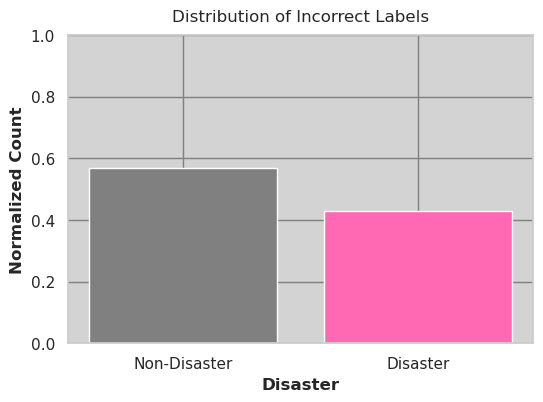

In [260]:
data_list = {
    0: 0.570,
    1: 0.430
}
# Setting up the plot style

sns.set(style="whitegrid", rc={"axes.facecolor": "lightgray", "grid.color": "gray"})

colors = ['gray', 'hotpink']

plt.figure(figsize=(6, 4))
plt.bar(data_list.keys(), data_list.values(), color=colors)
plt.xlabel('Disaster')
plt.ylabel('Normalized Count')
plt.title('Distribution of Incorrect Labels')
plt.xticks(list(data_list.keys()), ['Non-Disaster', 'Disaster'])
plt.ylim(0, 1) 
plt.show()

### Keyword Distribution (keyword)

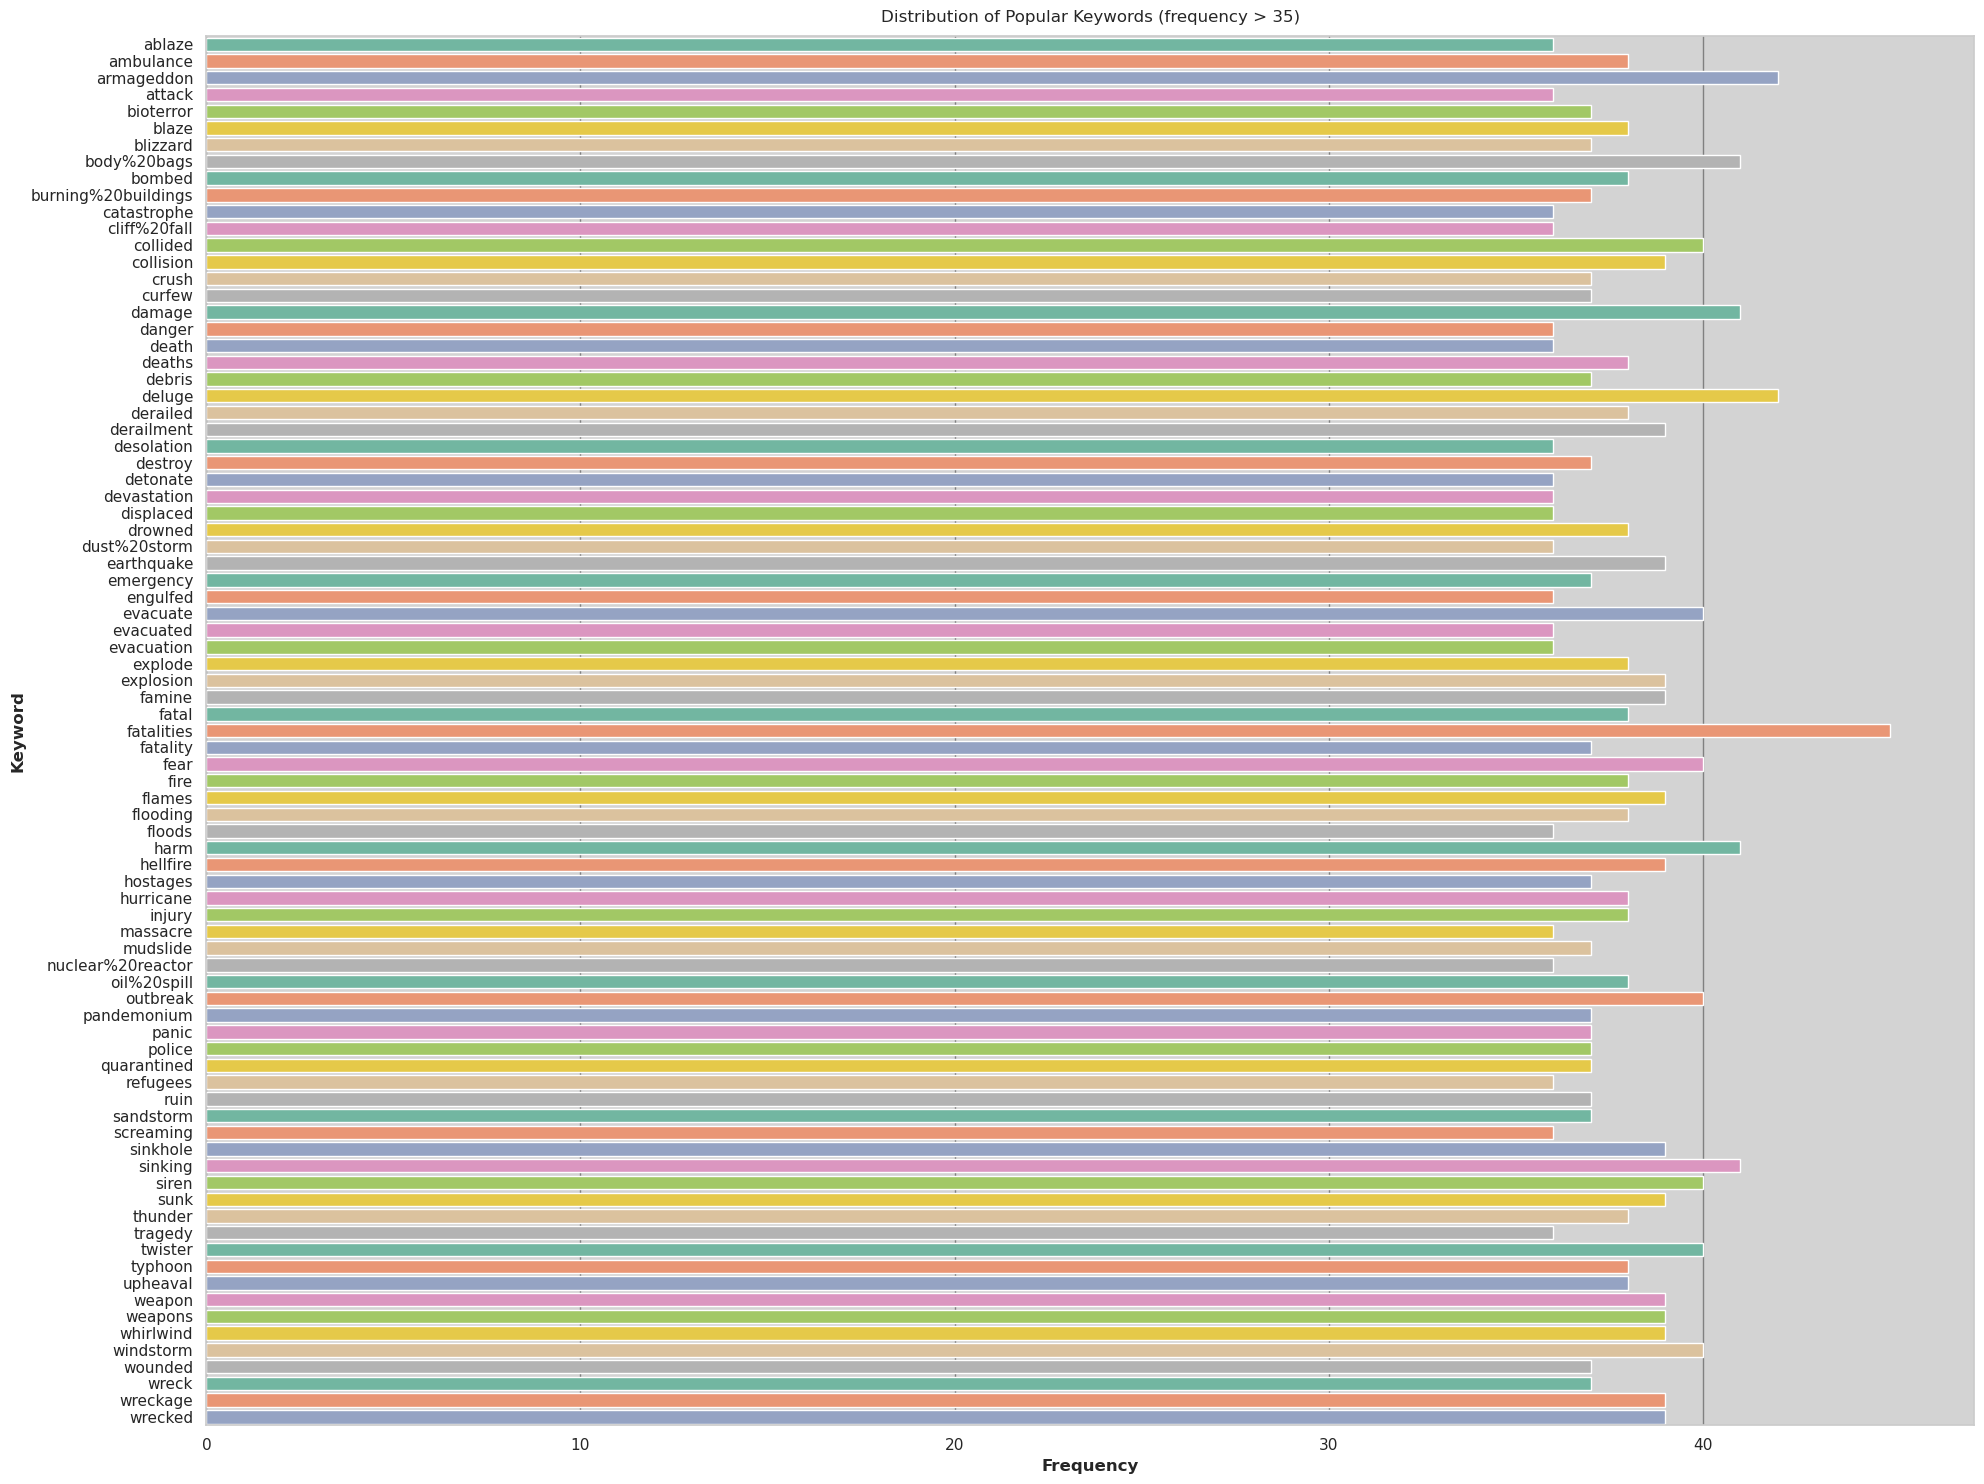

In [261]:
# Filtering Keywords by Frequency

keyword_counts = data_train["keyword"].value_counts()
popular_keywords = keyword_counts[keyword_counts > 35].index

# Filtering the dataset by popular keywords

popular_keywords_data = data_train[data_train["keyword"].isin(popular_keywords)]

# Setting the style for the graph

sns.set(style="whitegrid", rc={"axes.facecolor": "lightgray", "grid.color": "gray"})

# Creating the graph only if there is data to display

if not popular_keywords_data.empty:
    plt.figure(figsize=(20, 15))
    sns.countplot(data=popular_keywords_data, y="keyword", palette="Set2")

    # Customizing the appearance of the graph
    
    plt.title("Distribution of Popular Keywords (frequency > 35)")
    plt.xlabel("Frequency")
    plt.ylabel("Keyword")

    # Displaying the graph
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available for plotting.")

### Distribution of Locations (location)

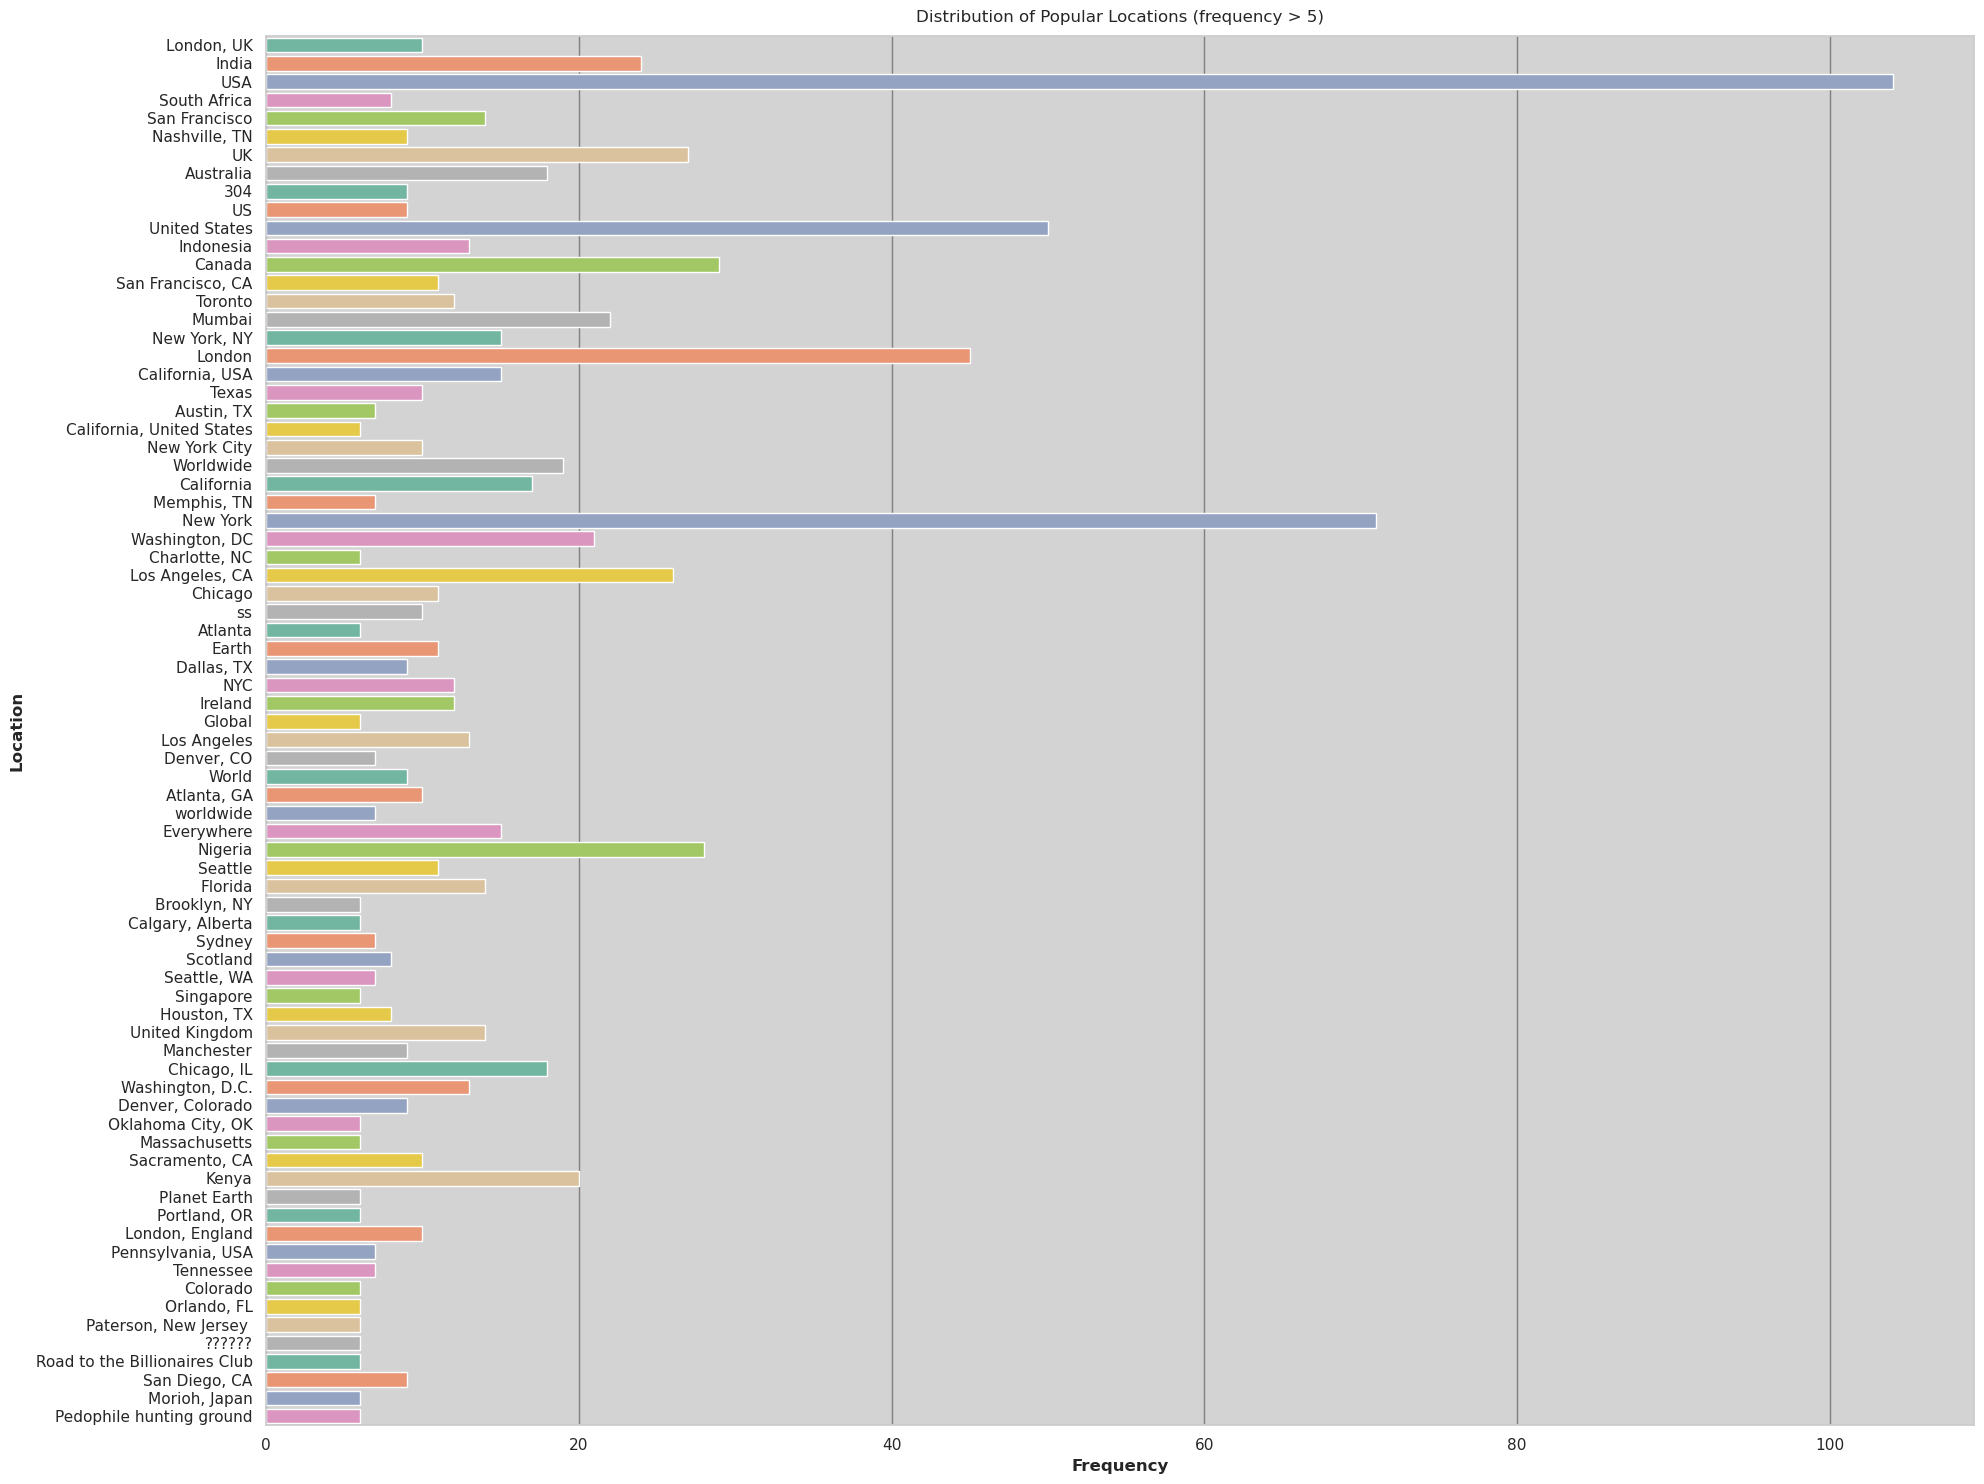

In [262]:
# Filtering Locations by Frequency

location_counts = data_train["location"].value_counts()
popular_locations = location_counts[location_counts > 5].index

# Filtering the dataset based on popular locations

popular_locations_data = data_train[data_train["location"].isin(popular_locations)]

# Setting up the visual style of the plot

sns.set(style="whitegrid", rc={"axes.facecolor": "lightgray", "grid.color": "gray"})

# Creating the plot if there is data to display

if not popular_locations_data.empty:
    plt.figure(figsize=(20, 15))
    sns.countplot(data=popular_locations_data, y="location", palette="Set2")

    # Customizing the appearance of the plot
    
    plt.title("Distribution of Popular Locations (frequency > 5)")
    plt.xlabel("Frequency")
    plt.ylabel("Location")

    # Displaying the plot
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available for plotting.")

### Length of Text Messages (text)

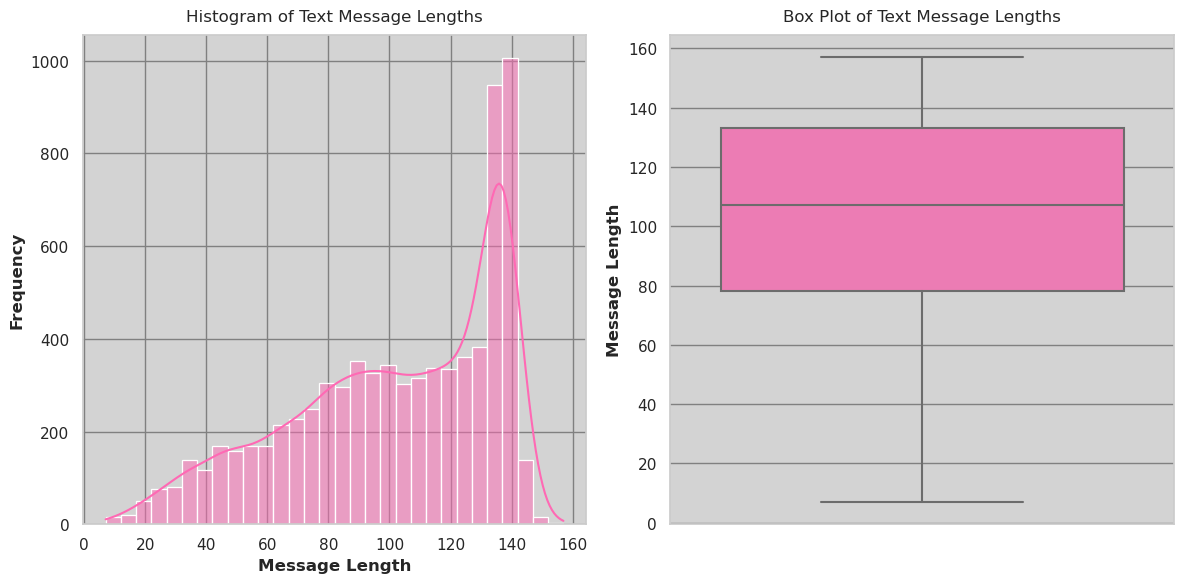

In [263]:
# Creating a Dataset Copy with an added Column

data_train_copy = data_train.copy()
data_train_copy["text_length"] = data_train_copy["text"].apply(len)

# Setting the Style for the Plot

sns.set(style="whitegrid", rc={"axes.facecolor": "lightgray", "grid.color": "gray"})

# Creating the Plots
plt.figure(figsize=(12, 6))

# Histogram of Text Message Lengths

plt.subplot(1, 2, 1)
sns.histplot(data=data_train_copy, x="text_length", bins=30, kde=True, color="hotpink")
plt.title("Histogram of Text Message Lengths")
plt.xlabel("Message Length")
plt.ylabel("Frequency")

# Box Plot for Text Message Length Distribution

plt.subplot(1, 2, 2)
sns.boxplot(data=data_train_copy, y="text_length", color="hotpink")
plt.title("Box Plot of Text Message Lengths")
plt.ylabel("Message Length")

# Displaying the Plots

plt.tight_layout()
plt.show()

### Correlation between Numerical Data

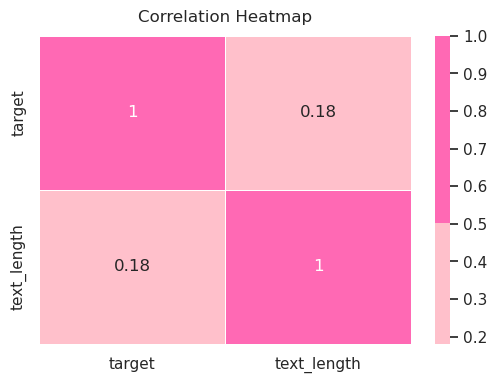

In [264]:
# Create a correlation matrix

correlation_matrix = data_train_copy[numeric_columns].corr()

# Customize your color palette

custom_palette = ["gray", "lightgray", "pink", "hotpink"]

# Create a correlation heatmap using your custom color palette

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap=sns.color_palette(custom_palette), center=0, linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

### Word Cloud (text)

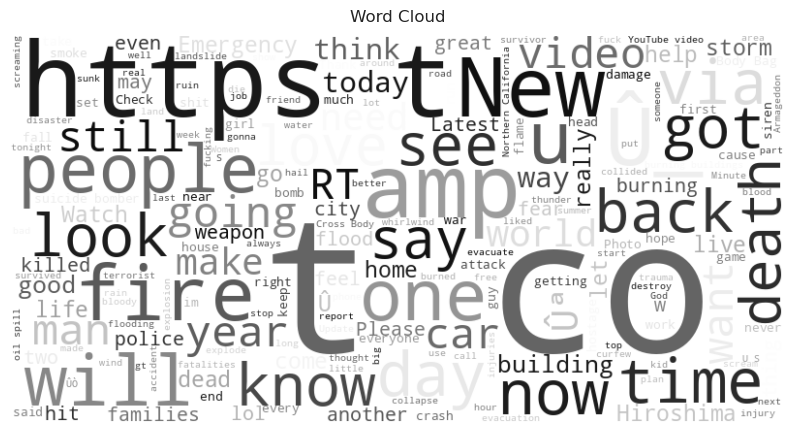

In [265]:
from wordcloud import WordCloud

# Combine all the text messages into a single string

all_text = " ".join(text for text in data_train['text'])

# Create a word cloud

wordcloud = WordCloud(width=800, height=400, background_color="white", colormap='gray').generate(all_text)

# Visualize the word cloud

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud")
plt.show()

### Message Length Distribution by Classes

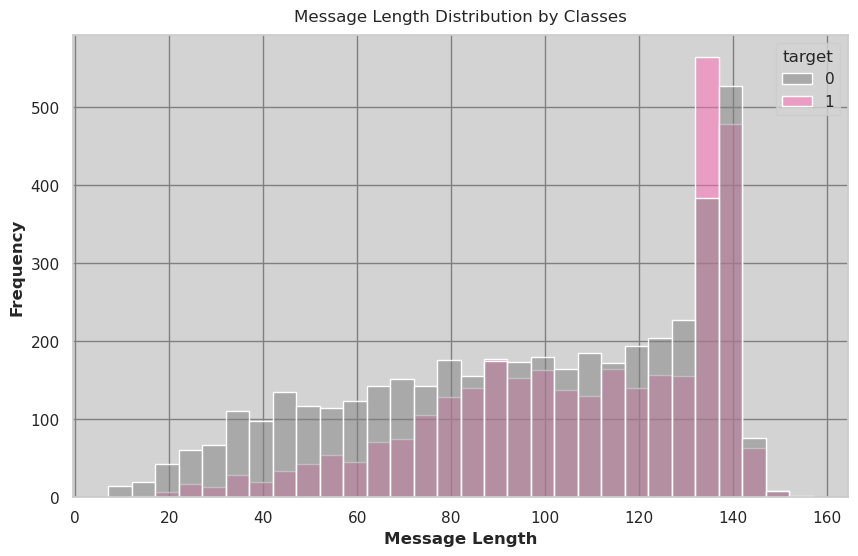

In [266]:
# Applying the plot style with a white grid background and gray gridlines
sns.set(style="whitegrid", rc={"axes.facecolor": "lightgray", "grid.color": "gray"})

# Creating a histogram plot to display the distribution of message lengths by classes
plt.figure(figsize=(10, 6))
sns.histplot(data=data_train_copy, x='text_length', hue='target', bins=30, palette=['gray', 'hotpink'])
plt.title("Message Length Distribution by Classes")
plt.xlabel("Message Length")
plt.ylabel("Frequency")
plt.show()

### Box Plot for Message Length by Classes

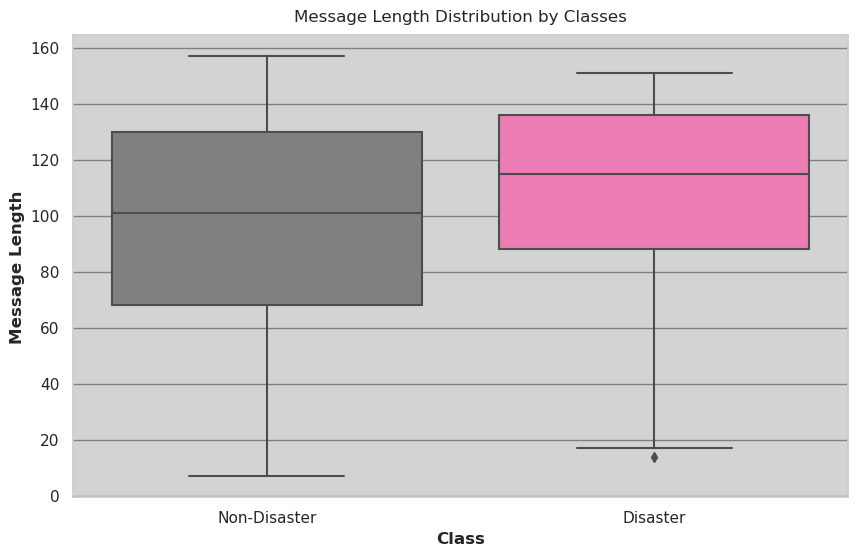

In [267]:
# Configure the plot style with a clean look

sns.set(style="whitegrid", rc={"axes.facecolor": "lightgray", "grid.color": "gray"})

plt.figure(figsize=(10, 6))
sns.boxplot(data=data_train_copy, x='target', y='text_length', palette=['gray', 'hotpink'])
plt.title("Message Length Distribution by Classes")
plt.xlabel("Class")
plt.ylabel("Message Length")
plt.xticks([0, 1], ['Non-Disaster', 'Disaster'])  
plt.show()

## Setup

In [268]:
# Replacing NaN values in the 'keyword' column with 'unknown'

data_train['keyword'].fillna('unknown', inplace=True)
data_test['keyword'].fillna('unknown', inplace=True)

In [269]:
data_train = data_train[['keyword','text','target']]
data_test = data_test[['keyword','text']]

In [270]:
data_train['text'] = data_train['text'].str.lower()
data_test['text'] = data_test['text'].str.lower()

In [271]:
data_train['text'] = data_train['text'].apply(lambda x: re.sub(r'[^a-zA-Z0-9]', ' ', x))
data_test['text'] = data_test['text'].apply(lambda x: re.sub(r'[^a-zA-Z0-9]', ' ', x))

In [272]:
nltk.download('punkt')

data_train['text'] = data_train['text'].apply(lambda x: nltk.word_tokenize(x))
data_test['text'] = data_test['text'].apply(lambda x: nltk.word_tokenize(x))

[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


In [273]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [ ]:
%%time

data_train['text'] = data_train['text'].apply(lambda x: [token.lemma_ for token in nlp(" ".join(x))])
data_test['text'] = data_test['text'].apply(lambda x: [token.lemma_ for token in nlp(" ".join(x))])

In [ ]:
%%time

data_train['text'] = data_train['text'].apply(lambda x: ' '.join(x))
data_test['text'] = data_test['text'].apply(lambda x: ' '.join(x))

## Training the Model

In [ ]:
# Merging the Columns: Keyword and Text

data_train['keyword_text'] = data_train['keyword'] + ' ' + data_train['text']
data_test['keyword_text'] = data_test['keyword'] + ' ' + data_test['text']

In [ ]:
# Picking the Right Columns for the Training Dataset

data_train = data_train[['keyword_text', 'target']]

In [ ]:
# Feature Extraction and Target Labeling

features = data_train['keyword_text']
target = data_train['target']
features_test = data_test['keyword_text']

In [ ]:
# Splitting the Data into Training and Testing Sets

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.2, random_state=12345, stratify=target)

In [ ]:
print(f"Number of rows in target_train by classes: {np.bincount(target_train)}")
print(f"Number of rows in target_valid by classes: {np.bincount(target_valid)}")

The class balance is quite close to being balanced. However, there's still some difference between the classes, which could impact the model's performance  

Here's the breakdown of the sample sizes:  

`Training Set (target_train):`  

>Class 0: 3473 observations  
Class 1: 2617 observations  

`Test Set (target_test):`  

>Class 0: 869 observations  
Class 1: 654 observations  

In this case, the class balance is relatively good, but there's a slight advantage in the number of observations for class 0. I would suggest keeping the current class balance and testing the model on this setup. Once the model is trained, we can evaluate its performance on the test set using the **F1-score metric**.

If it turns out that the model isn't achieving the desired performance due to the imbalance, we can consider trying various strategies such as class weighting, data augmentation, and so on.

In [ ]:
features_train.shape, features_valid.shape, target_train.shape, target_valid.shape 

In [ ]:
# Model building

logreg_model = LogisticRegression(random_state=12345)
pa_model = PassiveAggressiveClassifier(random_state=12345)

In [ ]:
# Building a pipeline with TF-IDF vectorization and a classifier

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words="english")), 
    ('clf', None)
])

In [ ]:
# Параметры для поиска по сетке

param_grids = [
    {
        'tfidf__ngram_range': [(1, 1), (1, 2)],  # For Logistic Regression
        'clf': [logreg_model],
        'clf__C': [1, 10, 100]
    },
    {
        'tfidf__ngram_range': [(1, 1), (1, 2)],  # For Passive Aggressive Classifier
        'clf': [pa_model],
        'clf__C': [1, 10, 100]
    }
]

In [ ]:
%%time

for param_grid in param_grids:
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        scoring=make_scorer(f1_score),
        cv=3
    )
    grid_search.fit(features_train, target_train)
    
    print(grid_search.best_params_)
    print(grid_search.best_score_)

In [ ]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [ ]:
f1_scores_logreg = grid_search.cv_results_['mean_test_score'][grid_search.best_index_]
f1_scores_pa = grid_search.cv_results_['mean_test_score'][grid_search.best_index_ + len(param_grids)]

print(f"F1 Score for Logistic Regression: {f1_scores_logreg:.4f}")
print(f"F1 Score for Passive Aggressive Classifier: {f1_scores_pa:.4f}")

In [ ]:
# Evaluating the Model using Cross-Validation

f1_scores_cv = grid_search.cv_results_['mean_test_score']
print('F1 Scores on Cross-Validation:', f1_scores_cv)

In [ ]:
# Creating a list of algorithms and their F1 score results

algorithms = ['Logistic Regression', 'Passive Aggressive Classifier']
f1_scores = [f1_scores_logreg, f1_scores_pa]  

In [ ]:
sns.set(style="whitegrid", rc={"axes.facecolor": "lightgray", "grid.color": "gray"})

# Creating the plot

plt.figure(figsize=(10, 6))
plt.plot(algorithms, [f1_scores_logreg, f1_scores_pa], marker='o', color='hotpink')

# Customizing the appearance of the plot

plt.title("Comparison of F1 Score Results")
plt.xlabel("Algorithm")
plt.ylabel("F1 Score")

# Displaying the plot

plt.tight_layout()
plt.show()

In [ ]:
# Predicting on the test set

predicted_labels_test = best_model.predict(features_test)

In [ ]:
sample_submission = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')

In [ ]:
submission_df = pd.DataFrame({
    'id': data_test.index,
    'target': predicted_labels_test
})

In [ ]:
final_submission = sample_submission[['id']].merge(submission_df, on='id', how='left')

In [ ]:
final_submission['target'].value_counts()

In [ ]:
final_submission.to_csv('/kaggle/working/submission.csv', index=False)